In [10]:
%%writefile fastapi_app.py
from fastapi import FastAPI
from pydantic import BaseModel
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load model & tokenizer
model = tf.keras.models.load_model("imdb_sentiment_model.h5")
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

max_len = 200

app = FastAPI(title="IMDB Sentiment API")

class Review(BaseModel):
    text: str

@app.post("/predict")
def predict_sentiment(review: Review):
    seq = tokenizer.texts_to_sequences([review.text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)[0][0]
    sentiment = "Positive" if pred > 0.5 else "Negative"
    return {"sentiment": sentiment, "score": float(pred)}


Writing fastapi_app.py


In [1]:
from google.colab import drive
import tarfile
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Set path to your file
file_path = '/content/drive/MyDrive/aclImdb_v1.tar.gz'  # change if in a different folder

# 3. Extract the tar.gz
extract_path = '/content/aclImdb'
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

# 4. Check contents
os.listdir(extract_path)


Mounted at /content/drive


/tmp/ipython-input-1385142146.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


['aclImdb']

In [2]:
import os
import pandas as pd

def load_imdb_to_df(folder):
    texts = []
    labels = []
    for label_type in ['pos', 'neg']:
        path = os.path.join(folder, label_type)
        for fname in os.listdir(path):
            if fname.endswith('.txt'):
                with open(os.path.join(path, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    df = pd.DataFrame({'review': texts, 'label': labels})
    return df

# Paths
train_folder = '/content/aclImdb/aclImdb/train'
test_folder = '/content/aclImdb/aclImdb/test'

# Load data into DataFrames
df_train = load_imdb_to_df(train_folder)
df_test = load_imdb_to_df(test_folder)

# Quick view
print(df_train.head())
print(df_train.shape)
print(df_test.shape)


                                              review  label
0  This James bond game is the best bond game i h...      1
1  I have probably seen this movie over fifty tim...      1
2  Eglimata (= Crimes) is a story about little cr...      1
3  Witty and disgusting. Brash and intelligent. B...      1
4  This is a good film for 99% of the duration. I...      1
(25000, 2)
(25000, 2)


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout

# Parameters

max_words = 10000
max_len = 200
embedding_dim = 128

# Tokenize text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['review'])

X_train = tokenizer.texts_to_sequences(df_train['review'])
X_test  = tokenizer.texts_to_sequences(df_test['review'])

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(X_test,  maxlen=max_len, padding='post', truncating='post')

y_train = np.array(df_train['label'])
y_test  = np.array(df_test['label'])

# Build LSTM model

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=128
)
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 483ms/step - accuracy: 0.6252 - loss: 0.6682 - val_accuracy: 0.0092 - val_loss: 1.3444
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 481ms/step - accuracy: 0.6384 - loss: 0.6597 - val_accuracy: 0.0000e+00 - val_loss: 0.9327
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.6097 - loss: 0.6666 - val_accuracy: 0.0000e+00 - val_loss: 0.9635
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.8455 - loss: 0.5506
Test Accuracy: 0.5000


In [4]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Parameters
max_words = 10000
max_len = 200
embedding_dim = 128

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['review'])

X_train = tokenizer.texts_to_sequences(df_train['review'])
X_test  = tokenizer.texts_to_sequences(df_test['review'])

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(X_test,  maxlen=max_len, padding='post', truncating='post')

y_train = df_train['label'].values
y_test  = df_test['label'].values

# Model
model = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=128
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.6108 - loss: 0.6685 - val_accuracy: 0.0078 - val_loss: 0.9132
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 481ms/step - accuracy: 0.6550 - loss: 0.6220 - val_accuracy: 0.2304 - val_loss: 0.9832
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.7164 - loss: 0.5501 - val_accuracy: 0.4308 - val_loss: 1.6990
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.8754 - loss: 0.3567
Test Accuracy: 0.6870


In [5]:
LSTM(128)
epochs=5-10


In [6]:
model.save("imdb_sentiment_model.h5")


In [7]:
def predict_review(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded)[0][0]
    return "Positive" if pred > 0.5 else "Negative"

predict_review("I loved this movie, it was amazing!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


'Positive'

In [8]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model
model.save('imdb_sentiment_model.h5')


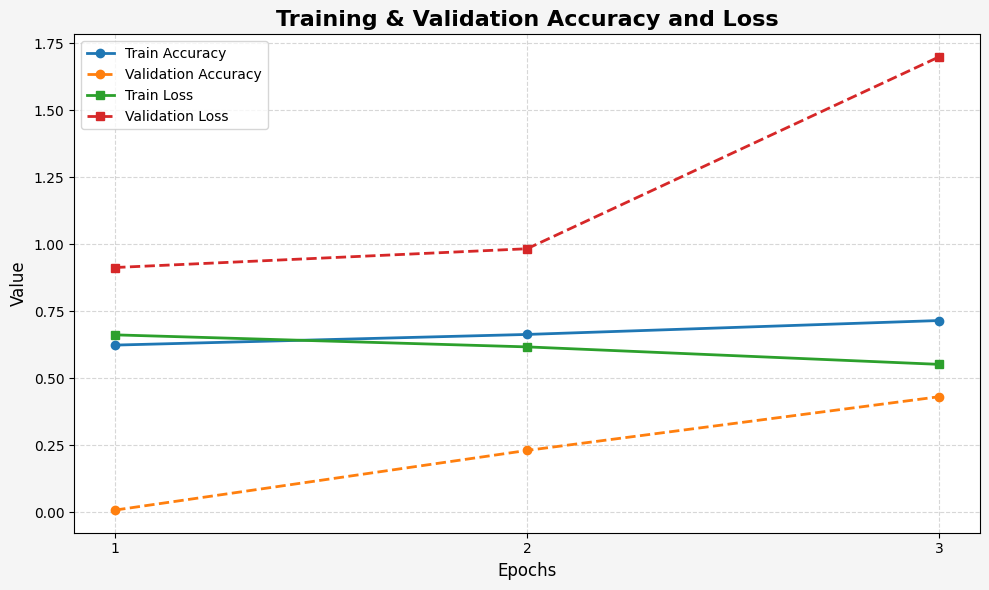

In [12]:
import matplotlib.pyplot as plt

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Create figure
plt.figure(figsize=(10,6), facecolor='#f5f5f5')

# Plot accuracy
plt.plot(epochs, acc, 'o-', color='#1f77b4', label='Train Accuracy', linewidth=2)
plt.plot(epochs, val_acc, 'o--', color='#ff7f0e', label='Validation Accuracy', linewidth=2)

# Plot loss on same graph
plt.plot(epochs, loss, 's-', color='#2ca02c', label='Train Loss', linewidth=2)
plt.plot(epochs, val_loss, 's--', color='#d62728', label='Validation Loss', linewidth=2)

# Titles and labels
plt.title('Training & Validation Accuracy and Loss', fontsize=16, weight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()
